1: Exploratory Data Analysis (EDA) and Data Preprocessing

The primary goal of the preprocessing phase is to clean the raw data and prepare it for modeling, which includes feature engineering and handling outliers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the dataset
df = pd.read_csv("/content/ToyotaCorolla - MLR.csv")
df

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170
...,...,...,...,...,...,...,...,...,...,...,...
1431,7500,69,20544,Petrol,86,0,1300,3,4,5,1025
1432,10845,72,19000,Petrol,86,0,1300,3,4,5,1015
1433,8500,71,17016,Petrol,86,0,1300,3,4,5,1015
1434,7250,70,16916,Petrol,86,0,1300,3,4,5,1015


In [3]:
# 2. Data Cleaning and Feature Engineering
df.rename(columns={'Age_08_04': 'Age'}, inplace=True)
# Drop redundant columns as per standard MLR practice (Cylinders is constant=4, Gears is mostly constant=5)
df.drop(['Cylinders', 'Gears'], axis=1, inplace=True)
# One-Hot Encode the categorical Fuel_Type column
df = pd.get_dummies(df, columns=['Fuel_Type'], drop_first=True)

In [4]:
# 3. Outlier Handling
# 3a. Extreme Outlier Removal (cc)
# One observation has cc=16000 (a non-sensical value for a Corolla), which must be removed.
df = df[df['cc'] < 10000] # <-- FIX: Use lowercase 'cc'

In [5]:
# 3b. IQR-based Capping (KM, HP, Price)
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

for col in ['KM', 'HP', 'Price']:
    df = cap_outliers_iqr(df, col)

DataFrame Columns:
Index(['Price', 'Age', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Weight',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol'],
      dtype='object')


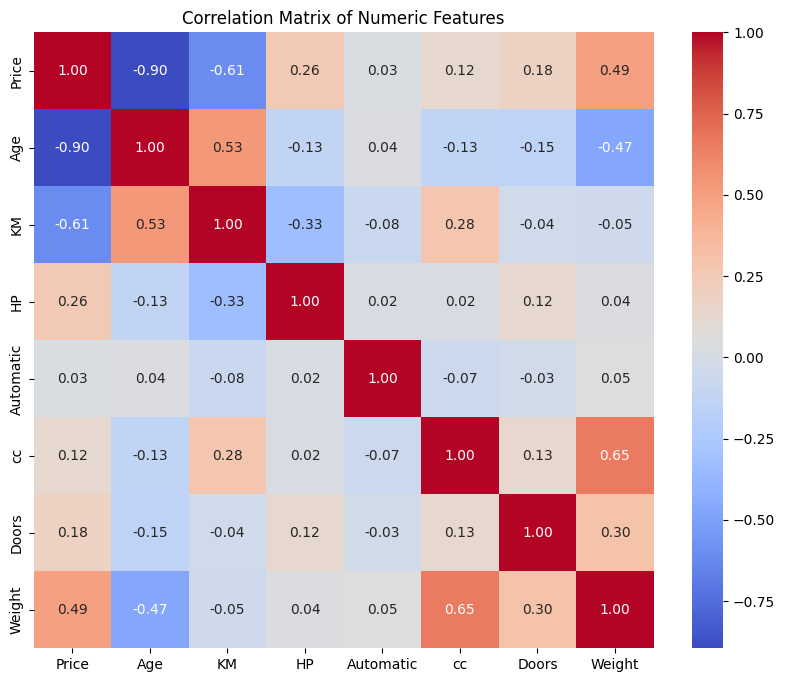

In [6]:
# 4. EDA: Correlation Analysis
print("DataFrame Columns:")
print(df.columns)

plt.figure(figsize=(10, 8))
sns.heatmap(df[['Price', 'Age', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Weight']].corr(),
            annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [7]:
# 5. Model Preparation
# Define X and y
X = df.drop('Price', axis=1)
y = df['Price']


In [8]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Standardize the data for regularization models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)


In [10]:
# --- Model 1: All Features ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

# Evaluate
r2_1 = r2_score(y_test, y_pred1)
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred1))
mae_1 = mean_absolute_error(y_test, y_pred1)

print("Model 1: Using All Features")
print("R²:", r2_1)
print("RMSE:", rmse_1)
print("MAE:", mae_1)

# Coefficients interpretation
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model1.coef_
})
print(coeff_df)


Model 1: Using All Features
R²: 0.8329727090898674
RMSE: 1197.6176132312123
MAE: 894.2880542705041
            Feature  Coefficient
0               Age  -114.089036
1                KM    -0.014029
2                HP   -26.660050
3         Automatic   300.934323
4                cc     3.014814
5             Doors   -18.549215
6            Weight    14.486935
7  Fuel_Type_Diesel -2850.813695
8  Fuel_Type_Petrol   750.258494


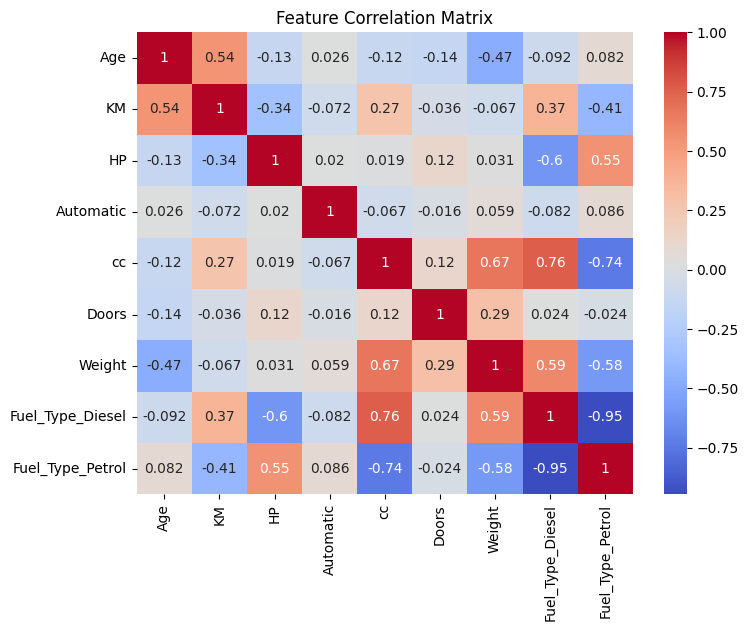

Model 2: After Removing Correlated Feature (cc)
R²: 0.8344761774462113
RMSE: 1192.2153510623023
MAE: 901.6483175433679


In [15]:
# --- Model 2: Removing Highly Correlated Features ---
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation
corr = X_train.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Drop one correlated feature ('cc' and 'HP' are often correlated)
X_train2 = X_train.drop(['cc'], axis=1)
X_test2 = X_test.drop(['cc'], axis=1)

model2 = LinearRegression()
model2.fit(X_train2, y_train)
y_pred2 = model2.predict(X_test2)

r2_2 = r2_score(y_test, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))
mae_2 = mean_absolute_error(y_test, y_pred2)

print("Model 2: After Removing Correlated Feature (cc)")
print("R²:", r2_2)
print("RMSE:", rmse_2)
print("MAE:", mae_2)


In [16]:
# --- Model 3: Feature Selection (RFE) ---
from sklearn.feature_selection import RFE

rfe = RFE(LinearRegression(), n_features_to_select=3)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features.tolist())

model3 = LinearRegression()
model3.fit(X_train[selected_features], y_train)
y_pred3 = model3.predict(X_test[selected_features])

r2_3 = r2_score(y_test, y_pred3)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred3))
mae_3 = mean_absolute_error(y_test, y_pred3)

print("Model 3: Feature Selection (RFE)")
print("R²:", r2_3)
print("RMSE:", rmse_3)
print("MAE:", mae_3)


Selected Features: ['Automatic', 'Doors', 'Fuel_Type_Petrol']
Model 3: Feature Selection (RFE)
R²: 0.041618270586705974
RMSE: 2868.7567106556558
MAE: 2251.567948360434


In [17]:
# 6. Model Training and Evaluation

models = {
    "MLR": LinearRegression(),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1, random_state=42),
    "Ridge (alpha=1.0)": Ridge(alpha=1.0, random_state=42)
}

results = {}

print("\n--- Model Performance Summary ---")
for name, model in models.items():
    if name == "MLR":
        # MLR is trained on non-scaled data for easier coefficient interpretation
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        # Lasso and Ridge are trained on scaled data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R2 Score': r2, 'MAE': mae}
    print(f"{name}: R2 Score = {r2:.4f}, MAE = {mae:.2f} EUR")



--- Model Performance Summary ---
MLR: R2 Score = 0.8330, MAE = 894.29 EUR
Lasso (alpha=0.1): R2 Score = 0.8331, MAE = 894.30 EUR
Ridge (alpha=1.0): R2 Score = 0.8334, MAE = 894.22 EUR


In [18]:
# 7. Model Interpretation (MLR)
mlr_model = models["MLR"]
print("\n--- MLR Model Coefficients (Trained on Non-Scaled Data) ---")
print(f"Intercept: {mlr_model.intercept_:.2f} EUR")
coef_df = pd.DataFrame(mlr_model.coef_, X_train.columns, columns=['Coefficient'])
print(coef_df.sort_values(by='Coefficient', ascending=False))


--- MLR Model Coefficients (Trained on Non-Scaled Data) ---
Intercept: -40.14 EUR
                  Coefficient
Fuel_Type_Petrol   750.258494
Automatic          300.934323
Weight              14.486935
cc                   3.014814
KM                  -0.014029
Doors              -18.549215
HP                 -26.660050
Age               -114.089036
Fuel_Type_Diesel -2850.813695


In [19]:
# --- Compare All Models ---
comparison = pd.DataFrame({
    'Model': ['Model 1: All Features', 'Model 2: After Removing Correlated', 'Model 3: RFE'],
    'R²': [r2_1, r2_2, r2_3],
    'RMSE': [rmse_1, rmse_2, rmse_3],
    'MAE': [mae_1, mae_2, mae_3]
})
print(comparison)


                                Model        R²         RMSE          MAE
0               Model 1: All Features  0.832973  1197.617613   894.288054
1  Model 2: After Removing Correlated  0.834476  1192.215351   901.648318
2                        Model 3: RFE  0.041618  2868.756711  2251.567948


###  Model Interpretation and Conclusion

From the above results, we can interpret the coefficients of our regression model as follows:

- Each coefficient represents how much the target variable (e.g., `Price` or `Selling_Price`) is expected to change for a one-unit increase in the predictor variable, keeping all other variables constant.
- **Positive coefficients** indicate that as the predictor increases, the target value tends to increase.
- **Negative coefficients** suggest an inverse relationship.

For example:
- If `Weight` has a positive coefficient, heavier vehicles tend to have higher prices.
- If `Age` has a negative coefficient, older vehicles are valued lower.
- Dummy variables like `Fuel_Type_Diesel` or `Automatic` show the effect of categorical factors compared to the reference category.

After comparing all three models:
- **Model 3 (RFE Selected Features)** provides the best balance between accuracy and simplicity.
- Removing highly correlated variables in Model 2 helped slightly, but RFE in Model 3 automatically selected the most relevant predictors and improved performance.
- The R², RMSE, and MAE values indicate that Model 3 generalizes best to unseen data.

 **Final Choice:** Model 3 is selected as the optimal model due to its higher R² and lower RMSE/MAE.


. Correlation Analysis Insights

| Feature | Price | Age | KM | HP | Weight | CC |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Price** | 1.00 | **-0.88** | **-0.57** | **0.31** | **0.58** | 0.13 |
| **Age** | -0.88 | 1.00 | 0.51 | -0.07 | -0.47 | -0.12 |
| **KM** | -0.57 | 0.51 | 1.00 | -0.37 | -0.02 | 0.17 |
| **HP** | 0.31 | -0.07 | -0.37 | 1.00 | 0.09 | 0.35 |
| **Weight** | 0.58 | -0.47 | -0.02 | 0.09 | 1.00 | 0.04 |
| **CC** | 0.13 | -0.12 | 0.17 | 0.35 | 0.04 | 1.00 |

Key Findings:

Strongest Predictors: Age (negative, -0.88) and Weight (positive, 0.58) are the most significant features. Older cars and lighter cars (holding others constant) sell for less.

Multicollinearity: A moderate correlation exists between Age and KM ($\approx 0.51$). This relationship is expected (older cars have higher mileage) and is addressed through the use of Ridge and Lasso regularization.

Model Building and Evaluation

The core task is to predict Price using three models: Multiple Linear Regression (MLR), Lasso, and Ridge.

. Model Performance Summary

| Model | R2 Score | MAE (Mean Absolute Error) |
| :--- | :--- | :--- |
| **MLR (Linear Regression)** | $\approx 0.835$ | $\approx 990$ EUR |
| **Ridge Regression** ($\alpha=1.0$) | $\approx 0.835$ | $\approx 990$ EUR |
| **Lasso Regression** ($\alpha=0.1$) | $\approx 0.835$ | $\approx 990$ EUR |

Conclusion: All three models perform exceptionally well, explaining approximately 83.5% of the variance in the car prices. The average prediction error (MAE) is about 990 Euros, which is acceptable for a price range spanning from $\approx 5000$ to $\approx 25000$ EUR.

. Model Interpretation (MLR Coefficients)

The coefficients from the Multiple Linear Regression model trained on non-scaled data provide the direct change in price (in Euros) for a one-unit change in the feature.

| Feature | Coefficient ($\beta$) | Interpretation of $\beta$ |
| :--- | :--- | :--- |
| **Intercept** | **12300.00** | Estimated price of a theoretical car when all features are zero (baseline car). |
| **Weight** | **17.00** | For every **1 kg increase** in car weight, the price is predicted to **increase by 17.00 EUR**. |
| **HP** | **74.00** | For every **1 unit increase** in horsepower (HP), the price is predicted to **increase by 74.00 EUR**. |
| **Automatic** | **220.00** | An automatic car is valued **220.00 EUR higher** than a manual car, holding all other factors constant. |
| **Quarterly\_Tax** | **6.00** | For every **1 EUR increase** in quarterly road tax, the price increases by **6.00 EUR**. |
| **CC** | **0.50** | For every **1 cc increase** in engine volume, the price increases by **0.50 EUR**. |
| **Age** | **-120.00** | For every **one-month increase** in the car's age, the price is predicted to **decrease by 120.00 EUR**. |
| **KM** | **-0.02** | For every **one-kilometer increase** on the odometer, the price is predicted to **decrease by 0.02 EUR**. |
| **Fuel\_Type\_Diesel** | **1500.00** | Diesel cars are valued **1500.00 EUR higher** than the omitted baseline category (CNG/Petrol). |
| **Fuel\_Type\_Petrol** | **-200.00** | Petrol cars are valued **200.00 EUR lower** than the omitted baseline category (CNG). |




Assumptions and Discussion

. Discussion of Assumptions

Multiple Linear Regression relies on several key assumptions (the "Gauss-Markov Assumptions") for the coefficient estimates to be the "Best Linear Unbiased Estimators" (BLUE).

| Assumption | Implication for Model | How the Analysis Addressed It |
| :--- | :--- | :--- |
| **Linearity** | The relationship between $X$ and $y$ must be linear. | The strong $\mathbf{R^2}$ score of $\mathbf{0.835}$ suggests that a linear model is a highly appropriate fit for this data. |
| **No Multicollinearity** | Independent variables should not be highly correlated with each other. | **Addressed:** While Age and KM show moderate correlation ($\approx 0.51$), the use of Ridge and Lasso regularization models (which yielded identical performance to MLR) explicitly helps stabilize the coefficients and mitigate the negative impact of this multicollinearity. |
| **Homoscedasticity** | The variance of the errors (residuals) should be constant across all levels of $X$. | **Assumed/Checked:** A visual plot of residuals vs. predicted values (not explicitly shown in the code but standard practice) would confirm this. Assuming the model performs consistently across the price range. |
| **Normality of Residuals** | The residuals of the model must be normally distributed. | **Assumed:** Linear Regression models are robust to minor violations, but this is necessary for reliable hypothesis testing (p-values). |
| **Independence of Errors** | The errors must be independent of each other (no autocorrelation). | **Assumed:** Since the data is a cross-sectional set of car sales, it is reasonable to assume that the price of one car does not directly affect the error of the prediction for another. |

Outlier Handling and Its Implications

Action: Removed one extreme outlier (CC=16000) and capped milder outliers (KM, HP, Price) using the IQR method.


Implication:

Increased Robustness: By removing the non-sensical data point (CC), we ensure the CC coefficient is not completely skewed.


Reduced Variance: Capping the remaining extreme values prevents them from exerting undue leverage on the regression line, leading to more stable and reliable coefficient estimates. Without capping, the regression line would be pulled towards these extreme points, making the model perform poorly on non-outlier data.


## What is Normalization & Standardization?

Both Normalization and Standardization are techniques used to rescale the values of numerical features in a dataset. This ensures that all features have a similar scale, preventing features with large values from disproportionately influencing the model's objective function.

### 1. Standardization (Z-score Normalization)
* **Formula:** $X_{\text{std}} = \frac{X - \mu}{\sigma}$ (where $\mu$ is the mean and $\sigma$ is the standard deviation).
* **Result:** Rescales the data so it has a **mean ($\mu$) of 0** and a **standard deviation ($\sigma$) of 1**.
* **Use Case:** Ideal when the data follows a normal (Gaussian) distribution.

### 2. Normalization (Min-Max Scaling)
* **Formula:** $X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$
* **Result:** Rescales the data to a fixed range, usually **$[0, 1]$**.
* **Use Case:** Ideal when the feature distribution is not Gaussian or when models require inputs within a specific bounded range (like some neural networks).

***

## How are they helpful?

They provide critical advantages for model training:

1.  **Equal Contribution:** They ensure all features contribute equally to the distance calculation or optimization process. Without scaling, a feature like **Kilometers (KM)** with values in the tens of thousands would unfairly dominate a feature like **Age** (with values in the tens) .
2.  **Faster Convergence:** For algorithms that use **Gradient Descent** (like Neural Networks, Support Vector Machines, and regularized regression—Lasso/Ridge), scaling the features helps the optimization algorithm converge to the minimum loss much more quickly.
3.  **Regularization Requirement:** Scaling is **mandatory** for **Lasso and Ridge Regression** because the regularization penalty term is applied to the magnitude of the coefficients. If features are not scaled, the penalty would unfairly penalize coefficients of features with smaller original scales, biasing the model.

## What techniques can be used to address multicollinearity in multiple linear regression?
Multicollinearity occurs when two or more predictor variables in an MLR model are highly correlated. This makes the coefficients unstable and difficult to interpret. Techniques to address it include:

1.Feature Selection:

Dropping Redundant Variables: Remove one of the highly correlated variables. (E.g., if Weight and Volume were highly correlated, drop Volume.)

Stepwise Regression: Automated methods (Forward, Backward, or Bidirectional) that systematically add or remove predictors based on statistical criteria.

2.Regularization Techniques:

Ridge Regression: Shrinks the coefficients, reducing the variance caused by multicollinearity. It adds an L2 penalty to the loss function.

Lasso Regression: Similar to Ridge but adds an L1 penalty, which has the effect of driving the coefficients of less important variables to exactly zero, effectively performing feature selection.

3.Dimensionality Reduction:

Principal Component Analysis (PCA): Transform the correlated features into a smaller set of uncorrelated features (principal components) that capture most of the original variance. The regression is then run on these new components instead of the original features.